# Data preparation

### Purpose of script
We prepare data for training and testing models to predict UGS in Houston.

### Steps

1. Preprocess Sentinel 2 data: (1) only keep necessary bands, (2) add some spectral indices, (3) export, and (4) merge.
2. Sample points in UGS and non-UGS regions, stratified by land cover type (nlcd), and export point shapefile.

In [416]:
import rasterio
from rasterio import features
import numpy as np
import os
import geopandas as gpd
from shapely.geometry import box
import matplotlib.pyplot as plt
import random
from numpy.random import RandomState
from pprint import pprint

In [3]:
os.getcwd()

'/Users/wenxinyang/Desktop/GitHub/UGS_iguide2024/script'

### Preprocess Sentinel 2 data

In [58]:
li_files = [x for x in os.listdir('../data/S2') if x.endswith('.tif')]

In [59]:
dat = rasterio.open(os.path.join('../data/S2', li_files[0]))

Check bands metadata [here](https://developers.google.com/earth-engine/datasets/catalog/COPERNICUS_S2_SR_HARMONIZED) to decide which bands to keep or remove.

In [60]:
dat.meta

{'driver': 'GTiff',
 'dtype': 'float64',
 'nodata': None,
 'width': 4864,
 'height': 4625,
 'count': 23,
 'crs': CRS.from_epsg(4326),
 'transform': Affine(8.983152841195215e-05, 0.0, -95.50717420854771,
        0.0, -8.983152841195215e-05, 29.780588973016727)}

In [61]:
dat.descriptions

('B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'AOT',
 'WVP',
 'SCL',
 'TCI_R',
 'TCI_G',
 'TCI_B',
 'MSK_CLDPRB',
 'MSK_SNWPRB',
 'QA10',
 'QA20',
 'QA60')

In [62]:
dat_bands = dat.read([2,3,4,8,11,12]) # blue, green, red, nir, swir1, swir2

After this, now the ordering of bands corresponds to:

0 - blue

1 - green

2 - red

3 - nir

4 - swir1

5 - swir2

After visual examination of land cover and satellite imagery in UGS in Houston, we add NDVI, NDWI, and NBR to the datasets. We follow formula on [Sentinelhub](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/ndvi/) to select bands to use.

In [63]:
type(dat_bands)

numpy.ndarray

In [64]:
def computeIndexAndReshape(data, i1, i2):
    index = (data[i1]-data[i2])/(data[i1]+data[i2])
#     index = index.reshape(1, index.shape[0], index.shape[1])
    return index

In [65]:
# ndvi = (nir - red)/(nir + red)
ndvi = computeIndexAndReshape(dat_bands, 3, 2)

# ndwi = (green - nir)/(green + nir)
ndwi = computeIndexAndReshape(dat_bands, 1, 3)

# nbr = (nir - swir)/(nir + swir)
nbr = computeIndexAndReshape(dat_bands, 3, 5)

In [66]:
dat_bands.shape

(6, 4625, 4864)

In [67]:
dat_bands1 = np.vstack([dat_bands,
                       ndvi[None, :, :],
                       ndwi[None, :, :],
                       nbr[None, :, :]])

In [68]:
dat_bands1.shape

(9, 4625, 4864)

Now we write out this new dataset. We first update metadata information, and then export.

In [70]:
metainfo = dat.meta
metainfo.update(
    dtype=rasterio.float32,
    count=dat_bands1.shape[0],
    compress='lzw'
)

In [69]:
li_files[0]

'2021_S2_Houston-0000004864-0000004864.tif'

In [71]:
with rasterio.open(os.path.join('../data/S2','file0.tif'), 'w', **metainfo) as dst:
    dst.write(dat_bands1)

After checking everthing works well, we write a big function and do the same for other images.
Note that after these steps, file size decreased because we got rid of unneeded bands.

In [77]:
def prepImage(li_img, i, indir, outdir):
    print('start working on '+str(i))
    dat = rasterio.open(os.path.join(indir, li_img[i]))
    dat_bands = dat.read([2,3,4,8,11,12]) # blue, green, red, nir, swir1, swir2
    
    # ndvi = (nir - red)/(nir + red)
    ndvi = computeIndexAndReshape(dat_bands, 3, 2)
    # ndwi = (green - nir)/(green + nir)
    ndwi = computeIndexAndReshape(dat_bands, 1, 3)
    # nbr = (nir - swir)/(nir + swir)
    nbr = computeIndexAndReshape(dat_bands, 3, 5)
    
    dat_bands1 = np.vstack([dat_bands,
                       ndvi[None, :, :],
                       ndwi[None, :, :],
                       nbr[None, :, :]])
    
    metainfo = dat.meta
    metainfo.update(
        dtype=rasterio.float32,
        count=dat_bands1.shape[0],
        compress='lzw'
    )
    
    with rasterio.open(os.path.join(outdir,"file"+str(i)+'.tif'), 'w', **metainfo) as dst:
        dst.write(dat_bands1)

In [87]:
for i in range(1, len(li_files)):
    prepImage(li_files, i, '../data/S2', '../data/S2')

start working on 1
start working on 2
start working on 3
start working on 4
start working on 5


### Sample UGS and non-UGS points

First rasterize UGS.

In [89]:
nlcd = rasterio.open('../data/2021_Houston_NLCD.tif')
prk = gpd.read_file('../data/park_hst/park_hst.shp')

In [106]:
nlcd.crs == prk.crs

False

In [108]:
# for convenience we convert the projection of prk to nlcd
prk_rpj = prk.to_crs(nlcd.crs)

In [109]:
bounds = nlcd.bounds
geom = box(*bounds)

In [112]:
# convert the cropped shapefile to a binary raster: 0 means non-UGS, 1 means UGS
indv_geom = [shapes for shapes in prk_rpj.geometry]
rasterized = features.rasterize(indv_geom,
                                out_shape = nlcd.shape,
                                fill = 0,
                                out = None,
                                transform = nlcd.transform,
                                all_touched = False,
                                default_value = 1,
                                dtype = None)

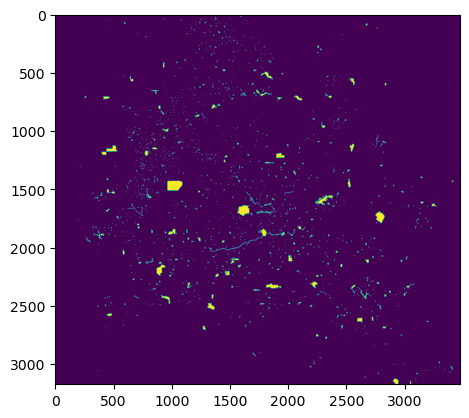

In [113]:
plt.imshow(rasterized)

In [114]:
# export
with rasterio.open(
    os.path.join('../data', 'prk_binary.tif'), "w",
    driver = "GTiff",
    crs = nlcd.crs,
    transform = nlcd.transform,
    dtype = rasterio.uint8,
    count = 1,
    width = nlcd.width,
    height = nlcd.height) as dst:
    dst.write(rasterized, indexes = 1)

dst.close()

In [115]:
type(rasterized)

numpy.ndarray

#### Stratified sampling

In [170]:
ugs_nlcd = ((rasterized*100))+nlcd.read(1)

In [172]:
np.unique(rasterized)

array([0, 1], dtype=uint8)

In [173]:
np.unique(nlcd.read(1))

array([ 0, 11, 21, 22, 23, 24, 31, 41, 42, 43, 52, 71, 81, 82, 90, 95],
      dtype=uint8)

In [182]:
np.unique(ugs_nlcd)

array([  0,  11,  21,  22,  23,  24,  31,  41,  42,  43,  52,  71,  81,
        82,  90,  95, 100, 111, 121, 122, 123, 124, 131, 141, 142, 143,
       152, 171, 181, 182, 190, 195], dtype=uint8)

In [178]:
unique, counts = np.unique(ugs_nlcd, return_counts=True)

In [179]:
dict_strat = dict(zip(unique, counts))

In [186]:
li1 = [x for x in dict_strat.values()][1:16]
li2 = [x for x in dict_strat.values()][17:32]

n = 5000

In [180]:
dict_strat

{0: 138464,
 11: 573114,
 21: 930367,
 22: 1349005,
 23: 1950870,
 24: 988629,
 31: 96473,
 41: 78477,
 42: 441490,
 43: 353698,
 52: 122865,
 71: 210357,
 81: 1970212,
 82: 764069,
 90: 742856,
 95: 166971,
 100: 763,
 111: 4448,
 121: 29803,
 122: 26471,
 123: 21296,
 124: 5686,
 131: 1078,
 141: 1563,
 142: 11133,
 143: 4891,
 152: 1087,
 171: 3026,
 181: 15707,
 182: 1510,
 190: 12969,
 195: 3954}

In [295]:
def getArrStrat(thedict, origarray, thekey, sumnum, totalsample):
    
    val = thedict.get(thekey)
    numsample = round(totalsample*val/sumnum)
    
    if(val!=0)
    
    grids_thiskey = np.unique(np.argwhere(origarray == key).flatten())
    rand_thiskey = random.sample(range(len(grids_thiskey)), numsample)
    
    arr = grids_thiskey[rand_thiskey]
    
    return(arr)

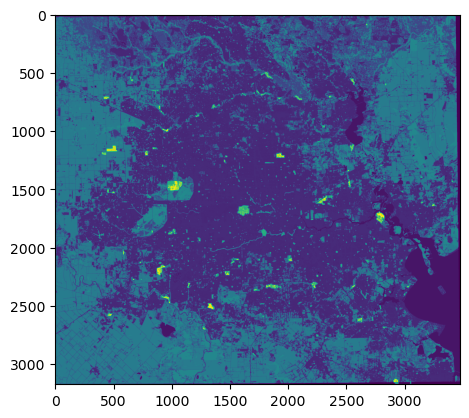

In [175]:
plt.imshow(ugs_nlcd)

In [389]:
ugs_nlcd_flt = ugs_nlcd.flatten()

In [390]:
# for non-ugs
li_nonugs_args = list()

for key in list(dict_strat.keys())[0:16]:
    arg = getArrStrat(dict_strat, ugs_nlcd_flt, key, sum(li1), 5000)
    li_nonugs_args.append(arg)
    
# for ugs
li_ugs_args = list()

for key in list(dict_strat.keys())[16:]:
    arg = getArrStrat(dict_strat, ugs_nlcd_flt, key, sum(li2), 5000)
    li_ugs_args.append(arg)

In [391]:
index_arr1 = np.hstack(li_nonugs_args)
index_arr2 = np.hstack(li_ugs_args)

In [392]:
len(index_arr1)

5065

In [308]:
import collections

In [393]:
dup1 = [item for item, count in collections.Counter(index_arr1).items() if count > 1]

In [400]:
out1 = np.zeros_like(ugs_nlcd_flt, dtype='int8')
np.put(out1, index_arr1, 1)
out1 = out1.reshape(ugs_nlcd.shape[0], ugs_nlcd.shape[1])

In [401]:
out2 = np.zeros_like(ugs_nlcd_flt, dtype='int8')
np.put(out2, index_arr2, 1)
out2 = out2.reshape(ugs_nlcd.shape[0], ugs_nlcd.shape[1])

In [405]:
out3 = out1 + out2

In [406]:
np.max(out3)

1

In [407]:
np.sum(out3)

10091

In [409]:
# export
with rasterio.open(
    os.path.join('../data', 'samp_pt.tif'), "w",
    driver = "GTiff",
    crs = nlcd.crs,
    transform = nlcd.transform,
    dtype = rasterio.uint8,
    count = 1,
    width = nlcd.width,
    height = nlcd.height) as dst:
    dst.write(out3, indexes = 1)

dst.close()

Almost there! Now let's convert the binary raster into a point polygon.

In [410]:
nlcd.meta

{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 3473,
 'height': 3174,
 'count': 1,
 'crs': CRS.from_wkt('PROJCS["Albers_Conical_Equal_Area",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]'),
 'transform': Affine(30.0, 0.0, 5355.0,
        0.0, -30.0, 794175.0)}

In [420]:
nlcd.meta['transform']

Affine(30.0, 0.0, 5355.0,
       0.0, -30.0, 794175.0)

In [421]:
shapes = features.shapes(out3, nlcd.meta['transform'])

In [434]:
import rioxarray

In [435]:
rds = rioxarray.open_rasterio("../data/samp_pt.tif")
rds.name = "data"

In [436]:
df = rds.squeeze().to_dataframe().reset_index()

In [437]:
geometry = gpd.points_from_xy(df.x, df.y)
gdf = gpd.GeoDataFrame(df, crs=rds.rio.crs, geometry=geometry)

In [ ]:
gdf.plot()